In [4]:
import mat73
import pickle
import joblib
import os
import sys
from tqdm import notebook

sys.path.append('../../libraries/') # Append the path within which the user-defined class is in
from data_loader import data_loader
from behavior_loader import bsoid_loader

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import umap
import hdbscan

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [7]:
data_dir = r'../../processed_data'

### Load 4-hour z-scored bandpower features of lpf using Welch method

In [9]:
zscore_feats = pickle.load(open(os.path.join(data_dir, 'welch_bp/welch_nonoverlap_zscore_bp_0.0_s_offset.np'), 'rb'))
print(f'Z-scored bandpower features are binned into shape: {zscore_feats.shape}')

Z-scored bandpower features are binned into shape: (48, 14400)


### Load best umap-hdbscan model that seperates lpf most clearly and predict on lpf features

In [10]:
def rf_f1_score(X, y, test_size=0.2, average='macro'):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return f1_score(y_test, predict, average=average)

In [17]:
def umap_hdbscan_rf_segment(data, n_components, n_neighbors, min_dist, random_state_umap, min_cluster_size, min_samples):
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state_umap)
    embedding = reducer.fit_transform(data)
    clusterer_umap = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, prediction_data=True).fit(embedding)
    X = data[clusterer_umap.labels_ >= 0, :]
    y = clusterer_umap.labels_[clusterer_umap.labels_ >= 0]
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X, y)
    y_all = clf.predict(data)

    return y_all

In [18]:
lfp_states = umap_hdbscan_rf_segment(data=zscore_feats.T,
                                     n_components=5,
                                     n_neighbors=60,
                                     min_dist=0,
                                     random_state_umap=29,
                                     min_cluster_size=300,
                                     min_samples=15)

In [21]:
lfp_states_10 = umap_hdbscan_rf_segment(data=zscore_feats.T,
                                     n_components=5,
                                     n_neighbors=60,
                                     min_dist=0,
                                     random_state_umap=29,
                                     min_cluster_size=150,
                                     min_samples=20)

In [19]:
len(np.unique(lfp_states))

6

In [22]:
len(np.unique(lfp_states_10))

10

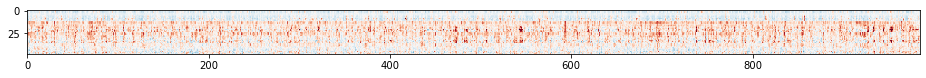

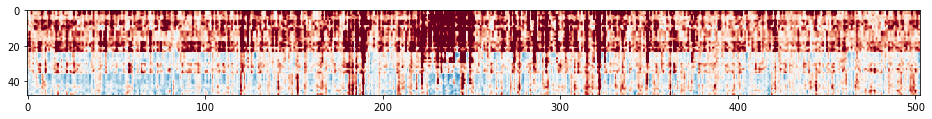

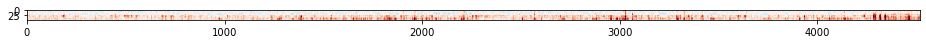

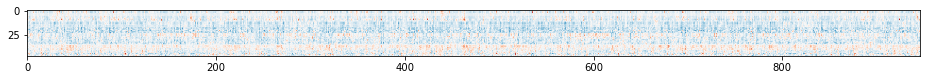

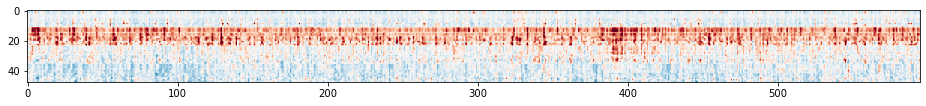

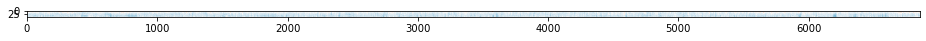

In [20]:
rows = len(np.unique(lfp_states))
cols = 1
for lfp_state in np.unique(lfp_states):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(lfp_states == lfp_state)[0]
    ax.imshow(zscore_feats[:, idx_], vmin=-3, vmax=3, cmap='RdBu_r')

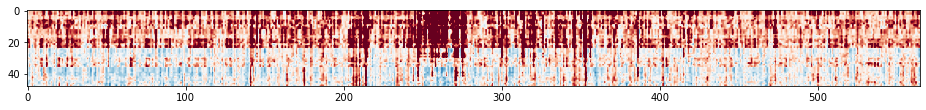

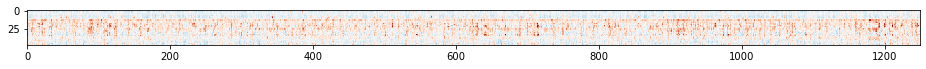

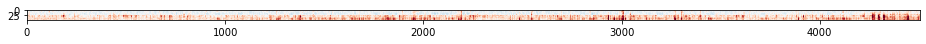

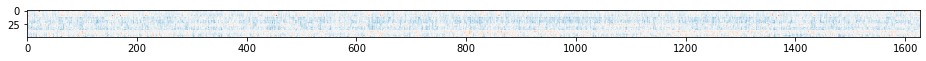

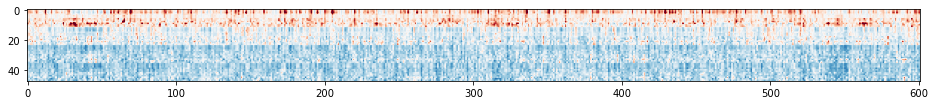

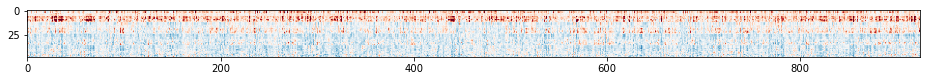

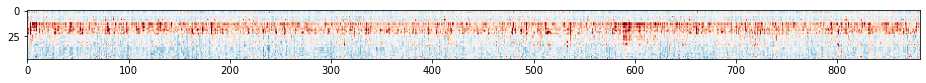

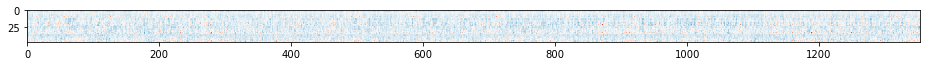

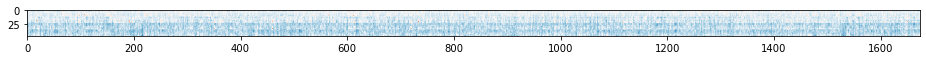

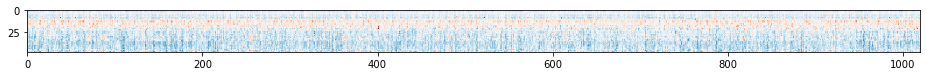

In [23]:
rows = len(np.unique(lfp_states_10))
cols = 1
for lfp_state in np.unique(lfp_states_10):
    fig, ax = plt.subplots(1, 1, figsize=(16, 11), sharex=True, sharey=True)
    idx_ = np.where(lfp_states_10 == lfp_state)[0]
    ax.imshow(zscore_feats[:, idx_], vmin=-3, vmax=3, cmap='RdBu_r')

In [24]:
zscore_feats.shape

(48, 14400)

In [98]:
X = zscore_feats[:, :200]

In [99]:
X.shape

(48, 200)

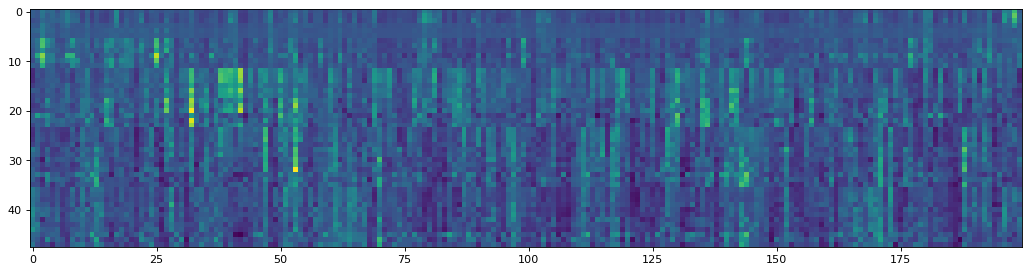

In [100]:
plt.figure(figsize=(16, 6), dpi=80)
plt.imshow(X)

## Naive repetitive windows

(144000,)


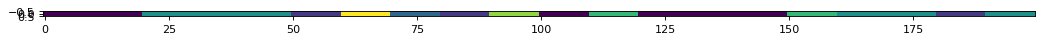

In [25]:
predict_naive = np.repeat(lfp_states_10, 10)
print(predict_naive.shape)
plt.figure(figsize=(16, 6), dpi=80)
plt.imshow(np.reshape(predict_naive[:200], (1, 200)))

In [26]:
np.unique(predict_naive, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 5650, 12490, 45050, 16270,  6010,  9240,  8820, 13530, 16740,
        10200]))

## Slide windows to pin down more precise transition windows

### Load 4-hour z-scored bandpower features of lpf extracted with 0.1s shift from 0 to 1s

In [110]:
zscore_feats_all = []
for offset in range(10):
    zscore_feats = pickle.load(open(os.path.join(data_dir, f'welch_bp/welch_nonoverlap_zscore_bp_0.{offset}_s_offset.np'), 'rb'))
    zscore_feats_all.append(zscore_feats)
zscore_feats_all = np.dstack(zscore_feats_all)

In [116]:
zscore_feats_all.shape

(48, 14400, 10)

In [119]:
zscore_feats_all[:, :1, 0].shape

(48, 1)

In [129]:
predict_sep = []
for offset in range(10):
    predict_sep.append(clf.predict(zscore_feats_all[:, :, offset].T))
predict_sep = np.vstack(predict_sep)
predict_sep.shape

(10, 14400)

In [144]:
predict_sliding = []
for col in range(predict_sep.shape[1]):
    predict_sliding.append(predict_sep[:, col])
predict_sliding = np.hstack(predict_sliding)
predict_sliding.shape

(144000,)

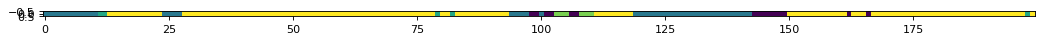

In [161]:
plt.figure(figsize=(16, 6), dpi=80)
plt.imshow(np.reshape(predict_sliding[:200], (1, 200)))

### Load 4-hour l5 spikes

In [27]:
with open(os.path.join(data_dir, 'all_fr0.1hz_30hz_0s_14400s_0.1s_bins_nooverlap.npy'), 'rb') as file:
    spike_times_all_neurons = np.load(file)

# Convert to numpy array
spike_times_all_neurons = np.array(spike_times_all_neurons)

# # (Number of 100-ms bins, Number of l2 neurons)
# T_1h, D_m1 = spike_times_all_neurons_1h.shape

# Z-score each neuron, i.e. firing rates of each neuron across time sum to 0
spike_times_all_neurons_4h_zscored = stats.zscore(spike_times_all_neurons) # Default axis is 0

spikes = spike_times_all_neurons_4h_zscored
print(f'Spike times are binned into shape: {spikes.shape}')

Spike times are binned into shape: (143999, 363)


In [28]:
spikes = np.vstack([spikes, np.random.rand(1, 363)])
spikes.shape

(144000, 363)

### Load 4-hour behaviors

In [29]:
# Load behaviors
behavior_loader = bsoid_loader(data_dir, 'ag25290_day2_iter13')
f_index, filtered_data, smoothed_predictions = behavior_loader.main()

# Correct prediction start
framerate = 60
delay = 6.8503
behavior_start = int(delay * framerate)  # start of behavior
smoothed_predictions_4h = smoothed_predictions[behavior_start:(behavior_start+(3600*60)*4):int(60/10)]
smoothed_predictions_4h.shape

Mouse stayed in nest for 0.28108749470484795% of time
Smooth window: 6
File #0 (a 6 body parts by 984391 frames) has 30 classes


(144000,)

In [30]:
np.unique(smoothed_predictions_4h, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], dtype=int32),
 array([  465,   562,   311,    33,   978,   769,   519,  1454, 12913,
        38000,  8826,  6237,    17,   123,   516,  1946,  8840,  1270,
         3357,  5532,   216,  2126,  4087,  1030,  3130,  3372,  5404,
        27294,   429,  4244]))

In [31]:
names = ['in-nest', 'torso groom', 'investigate type 0', 'unsure', 'wall rear type 1', 'rear',
         'unsure', 'wall rear type 2', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'sleep/scrunch type 1', 'sleep/scrunch type 2', 'wall rear type 3', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'ipsi-investigate',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'ipsi-itch type 2', 'face groom type 3', 
         'paw groom', 'locomotion', 'contra-forepaw orient', 'contra-orient']

In [32]:
len(names)

30

In [33]:
behav_names_mod = ['insignificant', 'insignificant', 'insignificant', 'insignificant', 'rear',
         'insignificant', 'insignificant', 'investigate type 1', 'investigate type 2', 'contra-itch',
         'investigate type 3', 'insignificant', 'insignificant', 'insignificant', 'contra-body groom',
         'face groom type 1', 'dive/scrunch', 'head groom', 'ipsi-orient', 'insignificant',
         'face groom type 2', 'ipsi-body groom', 'ipsi-itch type 1', 'insignificant', 'insignificant', 
         'paw groom', 'locomotion', 'insignificant', 'contra-orient']

In [34]:
len(behav_names_mod)

29

In [188]:
behav_names_mod[9]

'contra-itch'

### Classify behaviors within lfp brain states

In [35]:
def data_seg_prepare(data, targets, spikes, smoothed_predictions, random_state=10, limit_count=100, verbose=False):
    X = data.copy()
    y = targets.copy()
    X_subsampled = []
    y_subsampled = []
    spikes_subsampled = []
    smoothed_predictions_subsampled = []

    rng = np.random.default_rng(random_state)
    sig_behavs = [i for i, s in enumerate(behav_names_mod) if s != 'insignificant']
    for sig_behav in sig_behavs:
        idcs_s = np.where(y == sig_behav)[0]
        idcs_s_all = np.where(smoothed_predictions_4h == sig_behav)[0]
        try:
            sampled_idcs_s = rng.choice(len(idcs_s), limit_count, replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), limit_count, replace=False)
        except:
            sampled_idcs_s = rng.choice(len(idcs_s), len(idcs_s), replace=False)
            sampled_idcs_s_all = rng.choice(len(idcs_s_all), len(idcs_s), replace=False)
        y_subsampled.append(y[idcs_s[sampled_idcs_s]])
        X_subsampled.append(X[idcs_s[sampled_idcs_s], :])          
        smoothed_predictions_subsampled.append(smoothed_predictions[idcs_s_all[sampled_idcs_s_all]])
        spikes_subsampled.append(spikes[idcs_s_all[sampled_idcs_s_all], :])
            
    if verbose:
        print(np.hstack(y_subsampled).shape, np.vstack(X_subsampled).shape)

    return np.hstack(y_subsampled), np.vstack(X_subsampled), np.hstack(smoothed_predictions_subsampled), np.vstack(spikes_subsampled)

In [36]:
def rf_f1_score(X, y, test_size=0.2):
    sample_size = np.ceil(1 / test_size) * 4
    targets, target_cnts = np.unique(y, return_counts=True)
    X_train_arr = [] 
    X_test_arr = [] 
    y_train_arr = [] 
    y_test_arr = []
    for i, target_cnt in enumerate(target_cnts):
        if target_cnt >= sample_size:
            target_idcs = np.where(y == targets[i])[0]
            X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[target_idcs, :], y[target_idcs], test_size=test_size, random_state=42)
            X_train_arr.append(X_train_target)
            X_test_arr.append(X_test_target)
            y_train_arr.append(y_train_target)
            y_test_arr.append(y_test_target)
    X_train = np.vstack(X_train_arr)
    X_test = np.vstack(X_test_arr)
    y_train = np.hstack(y_train_arr)
    y_test = np.hstack(y_test_arr)
    clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)

    return np.unique(y_test), f1_score(y_test, predict, average=None)

### Map spikes to behaviors with respect to Naive lfp 10 segmentation

In [37]:
f1_score_diffs = []
f1_score_smooth_behav_arrs = []
for seed in notebook.tqdm(range(100, 201)):
    uiq_y_arr = []
    f1_score_diff = []
    f1_score_smooth_behav_arr = []
    for lfp_state in np.unique(predict_naive):
        seg_idcs = np.where(predict_naive == lfp_state)[0]
        state_spikes = spikes[seg_idcs, :]
        state_smoothed_predictions_4h = smoothed_predictions_4h[seg_idcs]
        
        state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
            data_seg_prepare(state_spikes, state_smoothed_predictions_4h, spikes, smoothed_predictions_4h, random_state=seed)
        
        uiq_y, f1_score_sep_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
        uiq_y_arr.append(uiq_y)
        
        _, f1_score_smooth_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

        f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
        f1_score_smooth_behav_arr.append(f1_score_smooth_behav)
    f1_score_smooth_behav_arrs.append(f1_score_smooth_behav_arr)
    f1_score_diffs.append(f1_score_diff)

  0%|          | 0/101 [00:00<?, ?it/s]

In [38]:
np.unique(predict_naive, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 5650, 12490, 45050, 16270,  6010,  9240,  8820, 13530, 16740,
        10200]))

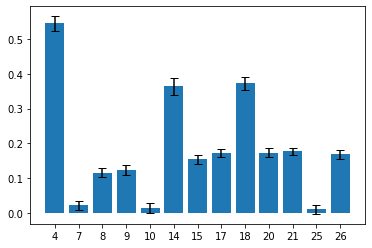

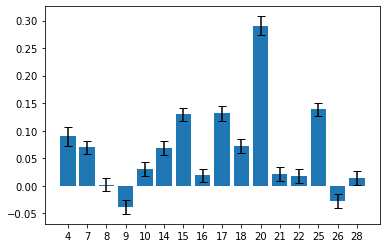

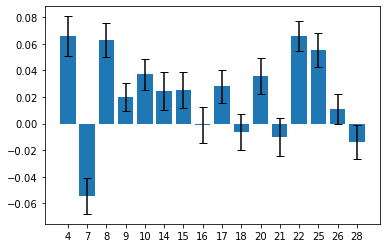

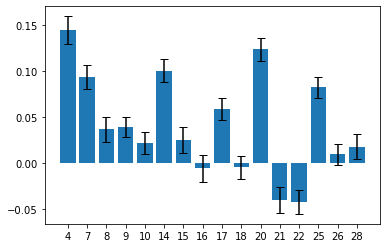

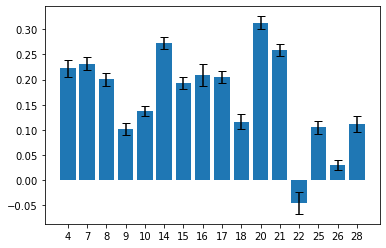

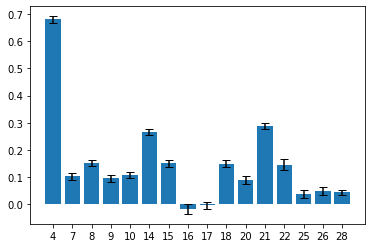

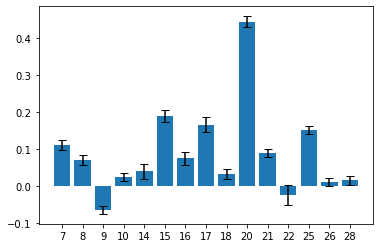

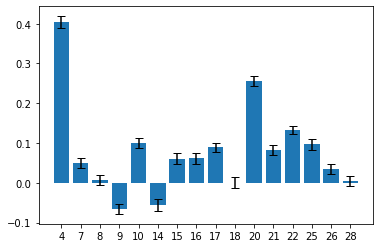

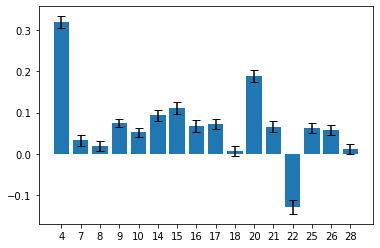

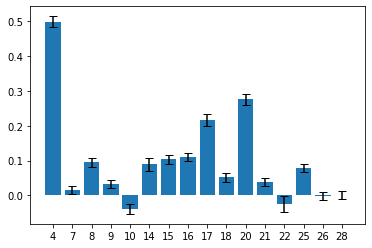

In [39]:
for i in range(len(np.unique(predict_naive))):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    plt.figure(i)
    plt.bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean)
    plt.errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=(state_f1_score_std/np.sqrt(100)), ecolor='black', capsize=4, fmt = ' ')
    plt.xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])

### Map spikes to behaviors with respect to Naive lfp 6 segmentation

In [183]:
f1_score_diffs = []
f1_score_smooth_behav_arrs = []
for seed in notebook.tqdm(range(100, 201)):
    uiq_y_arr = []
    f1_score_diff = []
    f1_score_smooth_behav_arr = []
    for lfp_state in np.unique(predict_naive):
        seg_idcs = np.where(predict_naive == lfp_state)[0]
        state_spikes = spikes[seg_idcs, :]
        state_smoothed_predictions_4h = smoothed_predictions_4h[seg_idcs]
        
        state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
            data_seg_prepare(state_spikes, state_smoothed_predictions_4h, spikes, smoothed_predictions_4h, random_state=seed)
        
        uiq_y, f1_score_sep_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
        uiq_y_arr.append(uiq_y)
        
        _, f1_score_smooth_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

        f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
        f1_score_smooth_behav_arr.append(f1_score_smooth_behav)
    f1_score_smooth_behav_arrs.append(f1_score_smooth_behav_arr)
    f1_score_diffs.append(f1_score_diff)

  0%|          | 0/101 [00:00<?, ?it/s]

In [187]:
np.unique(predict_naive, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 9850,  5030, 45180,  9460,  5950, 68530]))

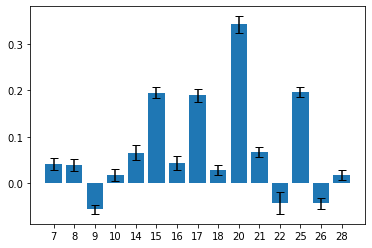

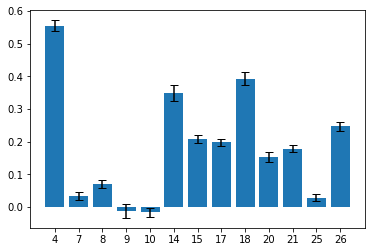

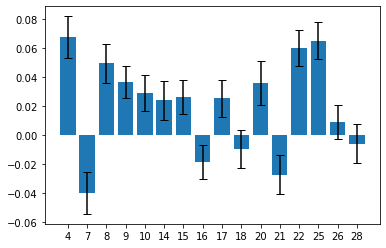

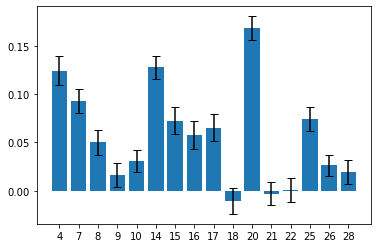

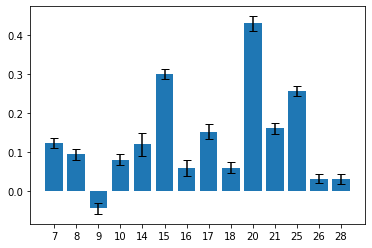

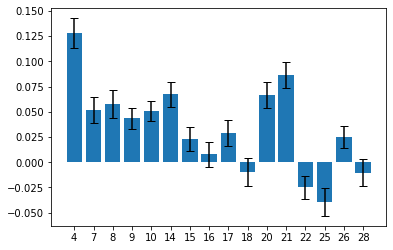

In [184]:
for i in range(len(np.unique(predict_naive))):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    plt.figure(i)
    plt.bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean)
    plt.errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=(state_f1_score_std/np.sqrt(100)), ecolor='black', capsize=4, fmt = ' ')
    plt.xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])

make a subplot with each behavior color (2x3), use seaborn to plot, error bar choice
check statistically different
look at band power plots
two sample t-test

### Map spikes to behaviors with respect to sliding window lfp segmentation

In [179]:
f1_score_diffs = []
f1_score_smooth_behav_arrs = []
for seed in notebook.tqdm(range(100, 201)):
    uiq_y_arr = []
    f1_score_diff = []
    f1_score_smooth_behav_arr = []
    for lfp_state in np.unique(predict_sliding):
        seg_idcs = np.where(predict_sliding == lfp_state)[0]
        state_spikes = spikes[seg_idcs, :]
        state_smoothed_predictions_4h = smoothed_predictions_4h[seg_idcs]
        
        state_smoothed_predictions_subsampled, state_spikes_subsampled, smoothed_predictions_subsampled, spikes_subsampled = \
            data_seg_prepare(state_spikes, state_smoothed_predictions_4h, spikes, smoothed_predictions_4h, random_state=seed)
        
        uiq_y, f1_score_sep_behav = rf_f1_score(state_spikes_subsampled, state_smoothed_predictions_subsampled)
        uiq_y_arr.append(uiq_y)
        
        _, f1_score_smooth_behav = rf_f1_score(spikes_subsampled, smoothed_predictions_subsampled)

        f1_score_diff.append(f1_score_sep_behav - f1_score_smooth_behav)
        f1_score_smooth_behav_arr.append(f1_score_smooth_behav)
    f1_score_smooth_behav_arrs.append(f1_score_smooth_behav_arr)
    f1_score_diffs.append(f1_score_diff)

  0%|          | 0/101 [00:00<?, ?it/s]

In [186]:
np.unique(predict_sliding, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 9739,  5070, 45449,  9024,  5975, 68743]))

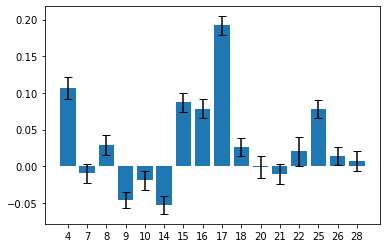

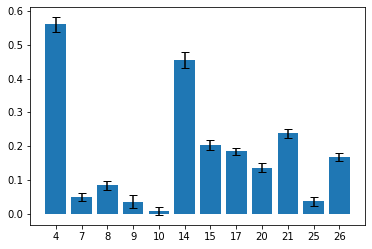

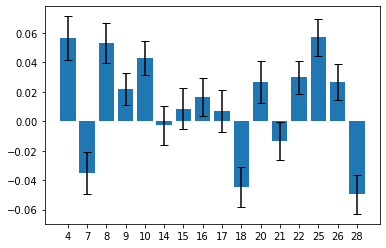

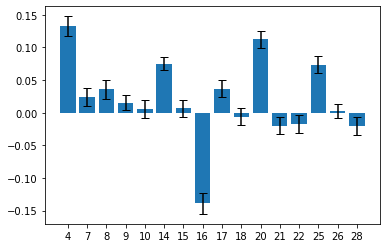

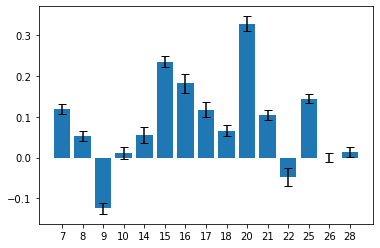

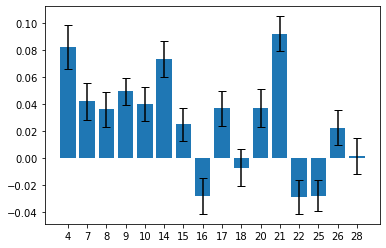

In [181]:
for i in range(len(np.unique(predict_naive))):
    state_f1_score_arr = []
    for f1_score_diff in f1_score_diffs:
        state_f1_score_arr.append(f1_score_diff[i])
    state_f1_score = np.vstack(state_f1_score_arr)
    state_f1_score_mean = np.mean(state_f1_score, axis=0)
    state_f1_score_std = np.std(state_f1_score, axis=0)

    plt.figure(i)
    plt.bar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean)
    plt.errorbar(np.arange(len(uiq_y_arr[i])), state_f1_score_mean, yerr=(state_f1_score_std/np.sqrt(100)), ecolor='black', capsize=4, fmt = ' ')
    plt.xticks(np.arange(len(uiq_y_arr[i])), uiq_y_arr[i])

predict body-groom rear degraded that are more 3-D

For Bad behavior look at video, 

behavoir trans into subtype and what it trans into

within state behaivor worse subtype has more variance than baseline

within state behaivor better subtype has more variance than baseline

worse behaviors are at decision boundary

explain the ones are doing better by linking to the trainsing beahvior previsojusly